# Delayed Acceptance example: Predator/Prey model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

Ray module not found. Multiprocessing features are not available


In [2]:
np.random.seed(987)

In [3]:
df = pd.read_csv('LynxHare.txt', delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['N', 'P']
df = df[-36:]; data = df.to_numpy()

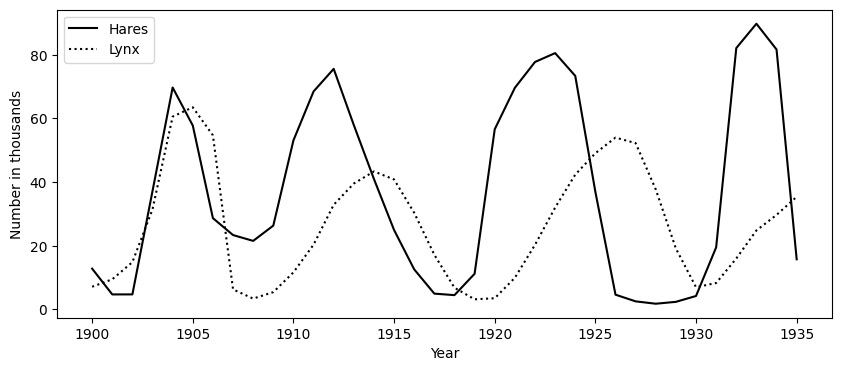

In [4]:
plt.figure(figsize=(10,4))
plt.plot(df.index, data[:,0], c='k', linestyle='solid', label='Hares')
plt.plot(df.index, data[:,1], c='k', linestyle='dotted', label='Lynx')
plt.xlabel('Year')
plt.ylabel('Number in thousands')
plt.legend()
#plt.savefig('tutorial_data.pdf', bbox_inches='tight')
plt.show()

### Define the predator/prey model
We use scipy.integrate.solve_ivp to solve the predator-prey model. The method `dydx` is the differential equation.

In [5]:
class PredatorPreyModel:
    def __init__(self, datapoints, method):
        
        # set the timesteps, where we are collecting the model output
        self.datapoints = datapoints
        
        # set the span of the integration.
        self.t_span = [0, self.datapoints[-1]]
        
        # set the integration method
        self.method = method
        
    def dydx(self, t, y, a, b, c, d):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

    def __call__(self, parameters):

        if np.any(parameters < 0):
            return 0

        # extract the parameters
        N_0, P_0, a, b, c, d = parameters

        # solve the initial value problem.
        self.sol = solve_ivp(lambda t, y: self.dydx(t, y, a, b, c, d), self.t_span, np.array([N_0, P_0]), t_eval=self.datapoints, method=self.method)
        
        # return the results, only if the integration succeeded.
        if self.sol.success:
            return self.sol.y.flatten()
        else:
            return 0
        
    def get_qoi(self):
        # collect the integration success status for diagnostics purposes
        return self.y.success

### Set up the forward models

In [6]:
t_span = [0, 35]
n_data = data.shape[0] # number of datapoints
t_eval_data = np.linspace(t_span[0], t_span[1], n_data) # datapoints

# model levels
model_l0 = PredatorPreyModel(t_eval_data, method='RK45')
model_l1 = PredatorPreyModel(t_eval_data, method='DOP853') 
model_l2 = PredatorPreyModel(t_eval_data, method='Radau')

### Set up the statistical model  and draw some samples from the prior
We need a fairly well-informed prior, since the model is nonlinear and the data is quite noisy. Hence, we assume that we have pretty good knowledge about the birth- and death rates of the prey and predators, respectively. The predation rate and the growth rate for the predators are left to be fairly uncertain.

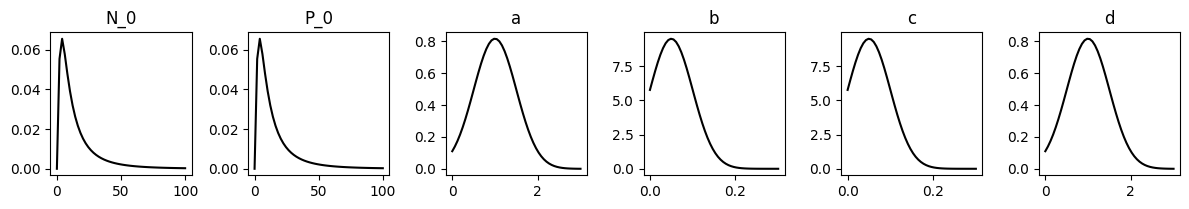

In [7]:
# prior distribution
N_prior = stats.lognorm(s=1, loc=0, scale=10)
P_prior = stats.lognorm(s=1, loc=0, scale=10)
a_prior = stats.truncnorm(a=-2, b=5, loc=1.0, scale=0.5)
b_prior = stats.truncnorm(a=-1, b=5, loc=0.05, scale=0.05)
c_prior = stats.truncnorm(a=-1, b=5, loc=0.05, scale=0.05)
d_prior = stats.truncnorm(a=-2, b=5, loc=1.0, scale=0.5)
my_prior = tda.CompositePrior([N_prior, P_prior, a_prior, b_prior, c_prior, d_prior])

# draw some samples and plot them
bounds = [(0,100), (0,100), (0,3), (0,0.3), (0,0.3), (0,3)]
titles = ['N_0', 'P_0', 'a', 'b', 'c', 'd']
fig, axes = plt.subplots(nrows=1, ncols=my_prior.dim, figsize = (12,2))
fig.tight_layout(pad=1.0)

for i in range(my_prior.dim):
    x = np.linspace(*bounds[i])
    p = my_prior.distributions[i].pdf(x)
    axes[i].set_title(titles[i])
    axes[i].plot(x, p, color='k')

In [8]:
# define the likelihood
sigma = 10.0
cov_likelihood = sigma**2*np.eye(data.size)

loglike_l2 = tda.GaussianLogLike(data.T.flatten(), cov_likelihood)
loglike_l1 = tda.AdaptiveGaussianLogLike(data.T.flatten(), cov_likelihood)
loglike_l0 = tda.AdaptiveGaussianLogLike(data.T.flatten(), cov_likelihood)

### Set up the posteriors and get the MAP point

In [9]:
# set up the posteriors
posterior_l2 = tda.Posterior(my_prior, loglike_l2, model_l2)
posterior_l1 = tda.Posterior(my_prior, loglike_l1, model_l1)
posterior_l0 = tda.Posterior(my_prior, loglike_l0, model_l0)

my_posteriors = [posterior_l0, posterior_l1, posterior_l2]

In [10]:
# get the maximum a posteriori point.
initial_guess = np.array([30, 5, 0.5, 0.025, 0.025, 1.0])
MAP = tda.get_MAP(posterior_l2, initial_guess)

/home/mikkel/venv/tinyda/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


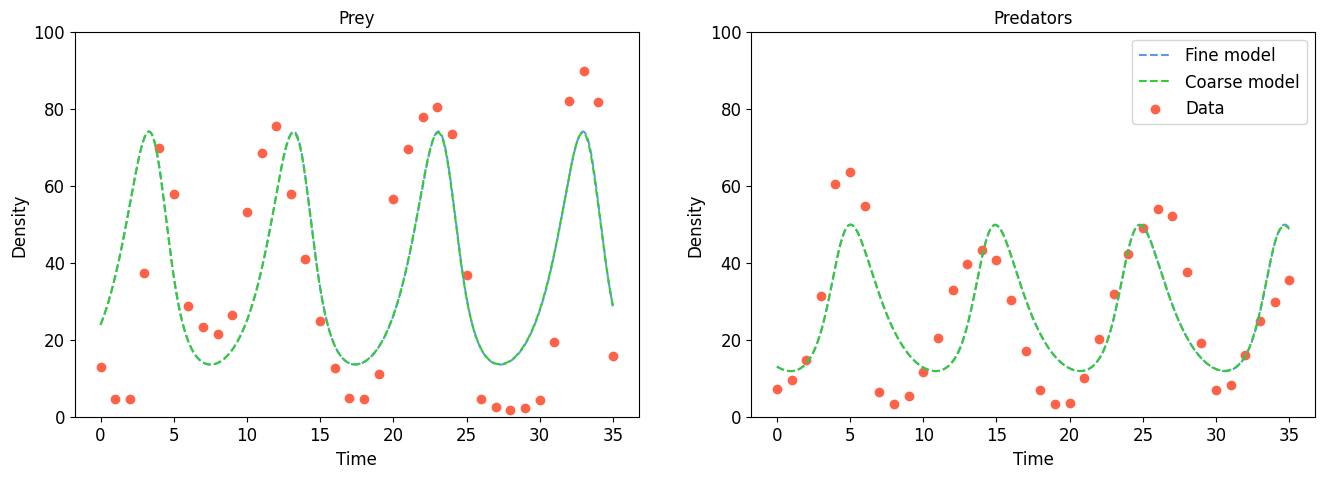

In [13]:
n_eval = 1000
t_eval = np.linspace(t_span[0], t_span[1], n_eval)

y_coarse = PredatorPreyModel(t_eval, method='RK45')(MAP)
y_fine = PredatorPreyModel(t_eval, method='Radau')(MAP)

fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_fine[:n_eval], '--', color='cornflowerblue')
axes[0].plot(t_eval, y_coarse[:n_eval], '--', color='limegreen')
axes[0].scatter(t_eval_data, data[:,0], color='tomato')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 100); axes[0].set_ylabel('Density', fontsize=12)
#axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_fine[n_eval:], '--', color='cornflowerblue', label='Fine model')
axes[1].plot(t_eval, y_coarse[n_eval:], '--', color='limegreen', label='Coarse model')
axes[1].scatter(t_eval_data, data[:,1], color='tomato', label='Data')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 100); axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(loc=1, fontsize=12)

plt.show()

### Set up the proposal

In [12]:
# Adaptive Metropolis
am_cov = np.diag([10, 10, 0.01, 0.001, 0.001, 0.01])
am_t0 = 100
am_sd = None
am_epsilon = 1e-6
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov,
                                     t0=am_t0,
                                     sd=am_sd,
                                     epsilon=am_epsilon,
                                     adaptive=am_adaptive)

### Sample

In [13]:
# initialise the chain
my_chain = tda.sample(my_posteriors,
                      my_proposal,
                      iterations=2500,
                      n_chains=4,
                      initial_parameters=MAP,
                      subsampling_rate=[3, 5],
                      adaptive_error_model='state-independent')

Sampling 4 chains in parallel


2023-05-05 13:39:12,279	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


### Diagnostics

In [14]:
import arviz as az

In [15]:
idata = tda.to_inference_data(my_chain, level=2, burnin=500)

/home/mikkel/venv/tinyda/lib/python3.8/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [16]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,24.494,2.877,19.156,29.886,0.128,0.091,506.0,918.0,1.01
theta_1,12.254,1.872,8.810,15.790,0.091,0.065,422.0,579.0,1.01
theta_2,0.754,0.111,0.562,0.963,0.006,0.004,348.0,363.0,1.01
theta_3,0.029,0.004,0.022,0.037,0.000,0.000,451.0,632.0,1.00
theta_4,0.017,0.002,0.013,0.022,0.000,0.000,402.0,505.0,1.00
theta_5,0.605,0.090,0.454,0.780,0.005,0.003,352.0,442.0,1.01


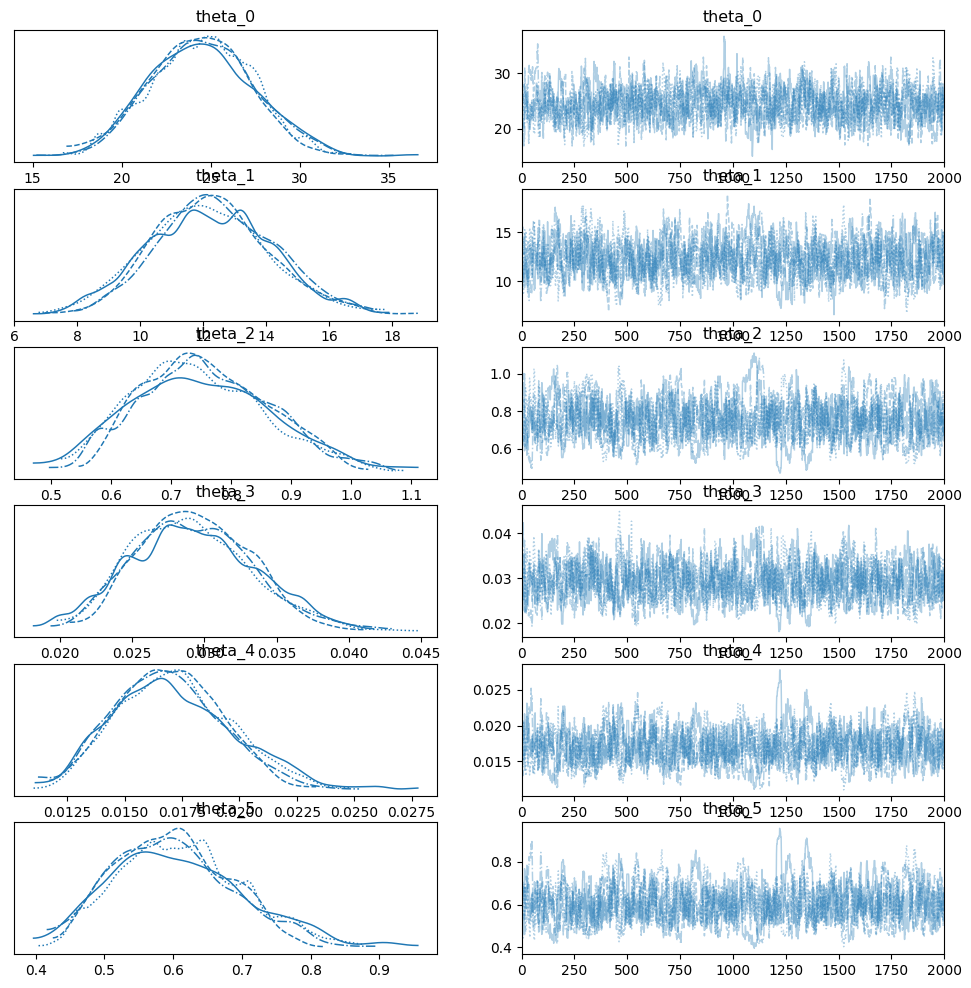

In [17]:
az.plot_trace(idata)
plt.show()

In [18]:
all_parameters = idata.posterior.to_dataframe().droplevel(level=0).to_numpy()

In [19]:
n_samples = 1000
samples = np.random.choice(all_parameters.shape[0], size=n_samples, replace=False)

model_plotting = PredatorPreyModel(t_eval, method='Radau')

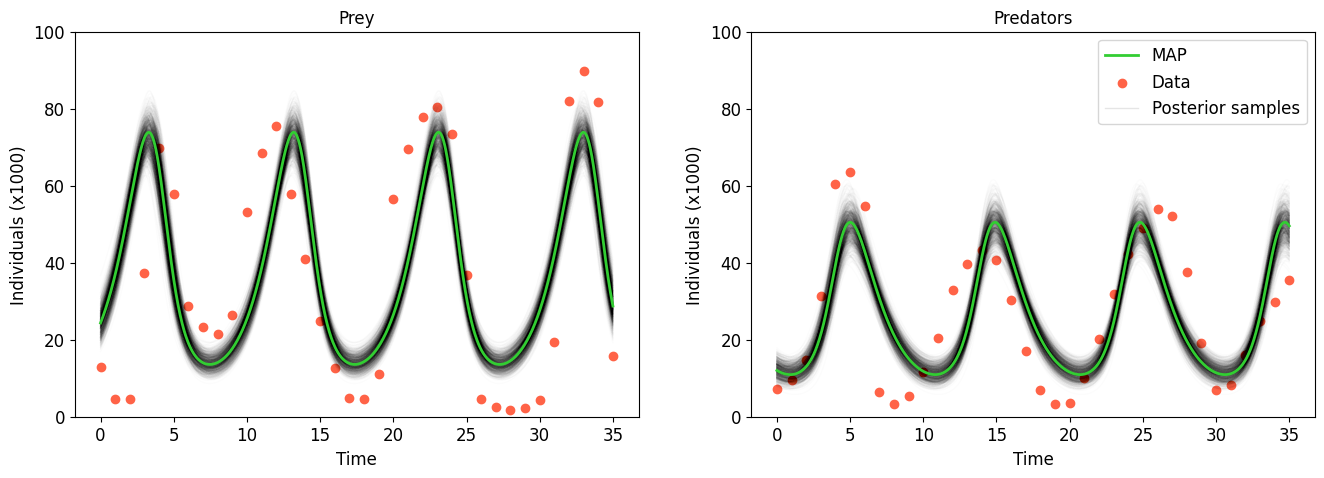

In [20]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

for s in samples:
    y_plotting = model_plotting(all_parameters[s,:])
    axes[0].plot(t_eval, y_plotting[:n_eval], color='k', linewidth=1, alpha=0.01)
    axes[1].plot(t_eval, y_plotting[n_eval:], color='k', linewidth=1, alpha=0.01)

y_plotting = model_plotting(MAP)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_plotting[:n_eval], color='limegreen', linewidth=2)
axes[0].scatter(t_eval_data, data[:,0], color='tomato')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 100); axes[0].set_ylabel('Individuals (x1000)', fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_plotting[n_eval:], color='limegreen', linewidth=2, label='MAP')
axes[1].scatter(t_eval_data, data[:,1], color='tomato', label='Data')
axes[1].plot([], [], color='k', linewidth=1, alpha=0.1, label='Posterior samples')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 100); axes[1].set_ylabel('Individuals (x1000)', fontsize=12)
axes[1].legend(loc=1, fontsize=12)

#plt.savefig('pp_samples.pdf', bbox_inches='tight')
plt.show()